<a href="https://colab.research.google.com/github/talhaanwarch/Eye_Disease_Classification_CNN/blob/master/inception_resnet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/talhaanwarch/Eye_Disease_Classification_CNN.git

Cloning into 'Eye_Disease_Classification_CNN'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 27 (delta 2), reused 5 (delta 1), pack-reused 21
Unpacking objects: 100% (27/27), done.


In [2]:
!unzip /content/Eye_Disease_Classification_CNN/Eye_diseases_dataset.zip

Archive:  /content/Eye_Disease_Classification_CNN/Eye_diseases_dataset.zip
   creating: Eye_diseases/
   creating: Eye_diseases/Bulging_Eyes/
  inflating: Eye_diseases/Bulging_Eyes/0_CATERS_WOMAN_WITH_RARE_CONDITION_MAKES_EYES_BULGE_01-572x1024.jpg  
 extracting: Eye_diseases/Bulging_Eyes/11_The_Burns_Archive_Hypert.jpg  
  inflating: Eye_diseases/Bulging_Eyes/13118203255_b8a3d638c1_z.jpg  
  inflating: Eye_diseases/Bulging_Eyes/15667.png.jpg  
  inflating: Eye_diseases/Bulging_Eyes/17067.jpg  
  inflating: Eye_diseases/Bulging_Eyes/29c3ce78d6f4b63257f465db0dd18c3f.jpg  
  inflating: Eye_diseases/Bulging_Eyes/29SoByS.jpg  
  inflating: Eye_diseases/Bulging_Eyes/2_CATERS_WOMAN_WITH_RARE_CONDITION_MAKES_EYES_BULGE_03-999x1024.jpg  
  inflating: Eye_diseases/Bulging_Eyes/340937.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/34AFC45300000578-3612499-image-m-6_1464346380762.jpg  
  inflating: Eye_diseases/Bulging_Eyes/3605204837_631bd97a95_b.jpg  
  inflating: Eye_diseases/Bulging_Eyes/3B-10

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

eye_cascade = cv2.CascadeClassifier('/content/Eye_Disease_Classification_CNN/haarcascade_eye.xml')

#read directory
import glob
#dirc=glob.glob('D:/Datasets/Image dataset/eye disease/eye-disease-dataset/Eye_diseases/*/')

path='/content/'
os.mkdir(path+'Cropped_Images/')
dir_names=os.listdir(path+'Eye_diseases/')
for dir_name in dir_names:
    counter=0
    os.mkdir(path+'Cropped_Images/'+dir_name)
    img_path=glob.glob(path+'Eye_diseases/{}/*.jpeg'.format(dir_name))
    for img in img_path:
        image=cv2.imread(img)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        eyes = eye_cascade.detectMultiScale(image)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(image,(ex,ey),(ex+ew,ey+eh),(255,255,255),1)
            #plt.imshow(image)

            crp=image[ey:ey+eh,ex:ex+ew,:]
            #plt.imshow(crp)
            plt.imsave(path+'Cropped_Images/{}/image_{}.jpg'.format(dir_name,counter),crp)
            counter+=1

In [4]:
os.listdir('/content/Cropped_Images')  # list of subdirectories and files


['Cataracts', 'Glaucoma', 'Uveitis', 'Bulging_Eyes', 'Crossed_Eyes']

In [5]:
os.walk('/content/Cropped_Images/')

<generator object walk at 0x7f93a61be678>

In [8]:
os.listdir(pic_dir)

['Cataracts', 'Glaucoma', 'Uveitis', 'Bulging_Eyes', 'Crossed_Eyes']

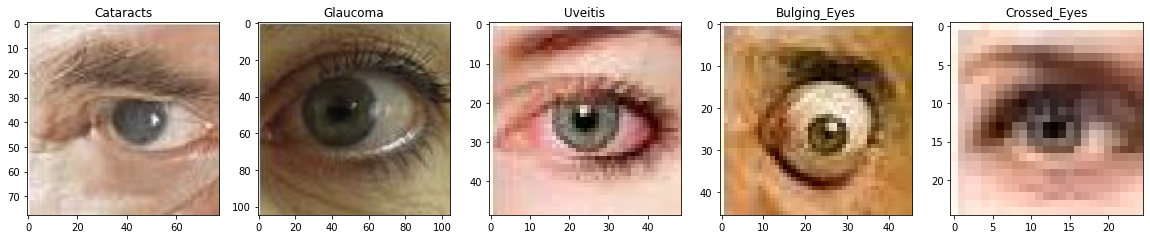

In [9]:
import random
from glob import glob

pic_dir='/content/Cropped_Images/'
folder=os.listdir(pic_dir)
fig,ax=plt.subplots(nrows=1,ncols=len(folder),figsize=(20,20))
for j,i in enumerate(folder):
  pic_path=random.choice(os.listdir(pic_dir+i))
  pic=cv2.imread(pic_dir+i+'/'+pic_path)
  pic=cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
  ax[j].imshow(pic)
  ax[j].set_title(i)

  

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.applications import densenet,inception_resnet_v2

In [0]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)

In [0]:

img_shape=299
batch_size=24

In [13]:
train_generator = data_gen.flow_from_directory(
    '/content/Cropped_Images',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 658 images belonging to 5 classes.


In [14]:
val_generator = data_gen.flow_from_directory(
    '/content/Cropped_Images',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False)

Found 279 images belonging to 5 classes.


In [15]:
model =inception_resnet_v2.InceptionResNetV2(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))

219062272/219055592 [==============================] - 3s 0us/step


In [0]:
for layer in model.layers:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['categorical_accuracy'])

In [20]:
results =model.fit(train_generator,epochs=15,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                             callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)]
                   )

Epoch 1/15
28/27 [==============================] - 28s 1s/step - loss: 1.5951 - categorical_accuracy: 0.4331 - val_loss: 1.3729 - val_categorical_accuracy: 0.4659 - lr: 0.0010
Epoch 2/15
28/27 [==============================] - 24s 864ms/step - loss: 1.3251 - categorical_accuracy: 0.5228 - val_loss: 1.4119 - val_categorical_accuracy: 0.4588 - lr: 0.0010
Epoch 3/15
28/27 [==============================] - 24s 868ms/step - loss: 1.2926 - categorical_accuracy: 0.5106 - val_loss: 1.3712 - val_categorical_accuracy: 0.4803 - lr: 0.0010
Epoch 4/15
28/27 [==============================] - 24s 863ms/step - loss: 1.2709 - categorical_accuracy: 0.5502 - val_loss: 1.3977 - val_categorical_accuracy: 0.5161 - lr: 0.0010
Epoch 5/15
28/27 [==============================] - 24s 851ms/step - loss: 1.2312 - categorical_accuracy: 0.5729 - val_loss: 1.2990 - val_categorical_accuracy: 0.5699 - lr: 0.0010
Epoch 6/15
28/27 [==============================] - 24s 853ms/step - loss: 1.2618 - categorical_accurac

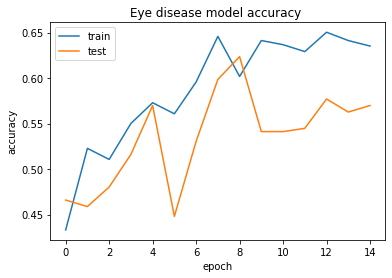

In [21]:

plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('Eye disease model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

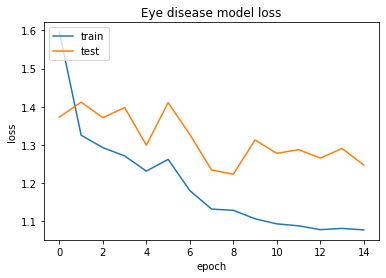

In [22]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Eye disease model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)
y_true = val_generator.classes
y_pred=np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

12/11 [==============================] - 7s 570ms/step
0.5734767025089605
0.41875556780089085


In [24]:

class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

Bulging_Eyes       0.55      0.50      0.52        64
   Cataracts       0.50      0.15      0.24        26
Crossed_Eyes       0.62      0.83      0.71       132
    Glaucoma       0.30      0.24      0.27        33
     Uveitis       0.60      0.25      0.35        24

    accuracy                           0.57       279
   macro avg       0.51      0.40      0.42       279
weighted avg       0.56      0.57      0.54       279

